In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue

/Library/Python/2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [46]:
tree_path = '/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_all_tree.json'
freqs_path = '/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_all_frequencies.json'
reference_path = '../../data/reference_seqs/genotype_refs_pyke2016.csv'
titer_path = '../../data/katzelnick2015/processed/genotypes_normalized.csv'

In [3]:
def assign_genotype_attr(tree, mrcas):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in ['genotype', 'genotype_mrca', 'clade_name']}
        
    for genotype, node in mrcas.items():
        node.traits['genotype_mrca'] = True
        node.traits['genotype'] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if 'genotype' in child.traits:
                if genotype != child.traits['genotype']:
                    print 'ERROR: Overlapping genotypes %s and %s at index %s'%(child.traits['genotype'], genotype, child.index)
            child.traits['genotype'] = genotype
    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    tree = bt.loadJSON(path) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits
            and node.traits['clade_name'] != 'DENV2_AMERICAN'}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

def load_all_frequencies(mrcas, path=freqs_path):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''    
    raw_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = raw_frequencies.pop('pivots') # [1917., 1918., ...]
    
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'0': [0.1, 0.23, ...] } }
    for label, freqs in raw_frequencies.items():
        if 'clade:' not in label: #south_america_II, africa_denv4_II
            split_label = label.split('_')

            if 'DENV' in label:
                region = '_'.join(split_label[:-2])
                clade = '_'.join(split_label[-2:])
            else:
                region = '_'.join(split_label[:-1])
                clade = '_'.join(split_label[-1:])
            try:
                clade = mrcas[clade].traits['clade']
            except:
                continue
                
        else: # 'global_clade:0'
            region, clade = label.split('_clade:')
            
        clade = int(clade) # the tree uses integers for clade indices
        regional_clade_frequencies[region][clade] = freqs 
        
    return {'frequencies': dict(regional_clade_frequencies), 
            'pivots': pivots }

def get_genotype_frequencies(mrcas, all_frequencies):
    genotype_frequencies = defaultdict(dict)
    
    for region in all_frequencies.keys():
        for genotype, mrca in mrcas.items():
            mrca_clade = mrca.traits['clade']
            genotype_frequencies[region][genotype] = all_frequencies[region][mrca_clade] 
    return dict(genotype_frequencies)

def make_dataframes(regions, genotype_frequencies, mindate=1970.):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    region_dfs = {}
    for region in regions:
        region_data = frequencies[region]
        df = pd.DataFrame(region_data, index=pivots)
        df = df.loc[df.index[df.index >= mindate]]
        region_dfs[region] = df
    return region_dfs

def annotate_references(tree, path=reference_path):
    refs = pd.read_csv(path, names=['serotype', 'genotype', 'year', 'accession', 'country', 'location'])
    refs['sero_geno'] = refs['serotype']+'_'+refs['genotype']
    ref_map = {acc:geno.upper() for (acc, geno) in zip(refs['accession'], refs['sero_geno'])}
    for k in tree.Objects:
        if k.branchType=='leaf' and k.traits['accession'] in ref_map:
            k.traits['reference_genotype'] = ref_map[k.traits['accession']]
    return tree

In [4]:
tmp = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = tmp['tree']
tree = annotate_references(tree)

# {'DENV2_AMERICAN': <baltic node>}
mrcas = tmp['mrcas']

# ['denv2_american', 'denv1_I', ...]
genotypes = tmp['genotypes']

tmp = load_all_frequencies(mrcas)

# {'south_america': 
#         {0: [ 0.2, 0.26, ....]},
#     }
all_frequencies = tmp['frequencies']
frequencies = get_genotype_frequencies(mrcas, all_frequencies) # {'south_america': {'asianI': []}}

# ['south_america', 'southeast_asia']
regions = frequencies.keys()

# [1917., 1918., ...]
pivots = tmp['pivots']

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)

# { 'southeast_asia': pd.DataFrame(columns=genotypes, index=pivots, values=frequencies)}
region_dfs = make_dataframes(regions, frequencies)


Tree height: 617.925450
Tree length: 14549.184390
annotations present

Numbers of objects in tree: 2988 (1425 nodes and 1563 leaves)

ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index NODE_0000211
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index NODE_0000212
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index DENV1/MALAYSIA/10245/1997
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index NODE_0000213
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index DENV1/MALAYSIA/3891/1995
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index DENV1/MALAYSIA/3928/1995
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index NODE_0000215
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index DENV1/MALAYSIA/7814/1996
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index NODE_0000216
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index DENV1/MALAYSIA/8064/1996
ERROR: Overlapping genotypes DENV1_IV and DENV1_I at index DENV1/MALAYSIA/7905/1996


In [5]:
print region_dfs['southeast_asia'].head()

           DENV1_I  DENV1_II  DENV1_IV  DENV1_V  DENV2_ASIANAMERICAN  \
1970.0000   0.1584    0.0036    0.0092      0.0               0.0764   
1970.0833   0.1577    0.0035    0.0092      0.0               0.0766   
1970.1667   0.1572    0.0035    0.0092      0.0               0.0769   
1970.2500   0.1566    0.0034    0.0091      0.0               0.0772   
1970.3333   0.1561    0.0033    0.0091      0.0               0.0774   

           DENV2_ASIANI  DENV2_COSMOPOLITAN  DENV2_SYLVATIC  DENV3_I  \
1970.0000        0.0757              0.0623          0.0445   0.0433   
1970.0833        0.0759              0.0625          0.0448   0.0429   
1970.1667        0.0762              0.0628          0.0452   0.0425   
1970.2500        0.0765              0.0630          0.0456   0.0420   
1970.3333        0.0767              0.0632          0.0459   0.0417   

           DENV3_II  DENV3_III  DENV3_IV  DENV4_I  DENV4_II  DENV4_SYLVATIC  
1970.0000    0.0519        0.0       0.0   0.0399    0.0

In [34]:
def plot_region_frequencies(region, dfs = region_dfs, date_range = None, pivots=pivots):
    plt.title(region)
    plt.xlabel('Year')
    plt.ylabel('Genotype Frequency')

    freqs = dfs[region]
    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for genotype, freqs in freqs.iteritems():
        plt.plot(pivots, freqs, color=colors[genotype], label=genotype)   
    
def plot_tree(tree):
    branchWidth=2 ## default branch width
    ll = tree
    xmax = max([k.absoluteTime for k in ll.Objects]) + 0.25

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        try:
            c = colors[k.traits['genotype']] if k.traits.has_key('genotype') else 'gray'
        except:
            c = 'orange'
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            if 'reference_genotype' in k.traits:
                c = 'red'
                plt.text(xmax,y,k.traits['reference_genotype'], ha='left', zorder=100, color=c)

            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

            if 'genotype_mrca' in k.traits:
#                 plt.text(xmax, y, str(k.traits['genotype']), ha='left', zorder=100)
                plt.text(x,y,str(k.traits['clade']), ha='right', zorder=100)
                try:
                    plt.text(k.parent.absoluteTime, k.parent.y, str(k.parent.traits['clade']), ha='right', zorder=100)
                except:
                    pass
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))


def plot_frequencies_and_tree():
    sns.set(style='whitegrid', font_scale = 1.3)
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(3,3, width_ratios=[1,1,2], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_frequencies('global', date_range=[1985., 1995.])
    plt.legend(loc=(2.5,-0.1), title="Dengue Genotypes", fontsize='large')
    globe.set_ylim([0, 1])

    south_america = plt.subplot(gs[1,:-1])
    plot_region_frequencies('south_america',date_range=[1985., 1995.])
    south_america.set_ylim([0, 1])
    
    southeast_asia = plt.subplot(gs[2, :-1])
    plot_region_frequencies('southeast_asia',date_range=[1985., 2014.])
    southeast_asia.set_ylim([0, 1])
        
    sns.set(style = 'white', font_scale = 1.3)
    treeplot = plt.subplot(gs[:,-1])
    plot_tree(tree)
        
    plt.tight_layout()
    plt.show()
    
def plot_subtrees(tree):
    sns.set(style='whitegrid', font_scale=1.3)
    figure = plt.figure(figsize=(10,50))
    serotype_mrcas = [('DENV1', 1857), ('DENV2', 1), ('DENV3', 1384), ('DENV4', 967)]
    for i, (serotype, mrca) in enumerate(serotype_mrcas, start=1):
        plt.subplot(4, 1,i)
        mrca = [k for k in tree.Objects if k.branchType=='node' and k.traits['clade'] ==mrca][0]
        subtree = tree.subtree(mrca)
        plot_tree(subtree)
    plt.tight_layout()
    plt.show()

In [30]:
def update_mrcas(mrcas=mrcas, tree=tree):
    for genotype, mrca in mrcas.items():
        if not isinstance(mrca, bt.node):
            mrcas[genotype] = [k for k in tree.nodes if k.traits['clade'] == mrca][0]
    genotype_frequencies = get_genotype_frequencies(mrcas, all_frequencies)
    tree = assign_genotype_attr(tree, mrcas)
    region_dfs = make_dataframes(regions, genotype_frequencies)
    return {'frequencies': genotype_frequencies, 'tree': tree, 'region_dfs': region_dfs}

mrcas['DENV1_I'] = 1858
mrcas['DENV1_IV'] = 2231
mrcas['DENV1_V'] = 2589
mrcas['DENV1_II'] = 2582

mrcas['DENV2_AMERICAN'] = 33
mrcas['DENV2_ASIANII'] = 494
# mrcas['DENV2_ASIANI'] = 
# mrcas['DENV2_'] = 

# mrcas['DENV3_III'] = 1583
# mrcas['DENV3_I'] = 1459
# mrcas['DENV3_V'] = 1454
# mrcas['DENV3_II'] = 1392
# mrcas['DENV3_'] = 

# mrcas['DENV4_'] = 
# mrcas['DENV4_'] = 
# mrcas['DENV4_'] = 
# mrcas['DENV4_'] = 


# mrcas['I'] = 13
# mrcas['SYLVATIC'] = 1
genotypes = mrcas.keys()
colors = assign_genotype_colors(genotypes)
tmp = update_mrcas()
frequencies = tmp['frequencies']
tree = tmp['tree']
region_dfs = tmp['region_dfs']

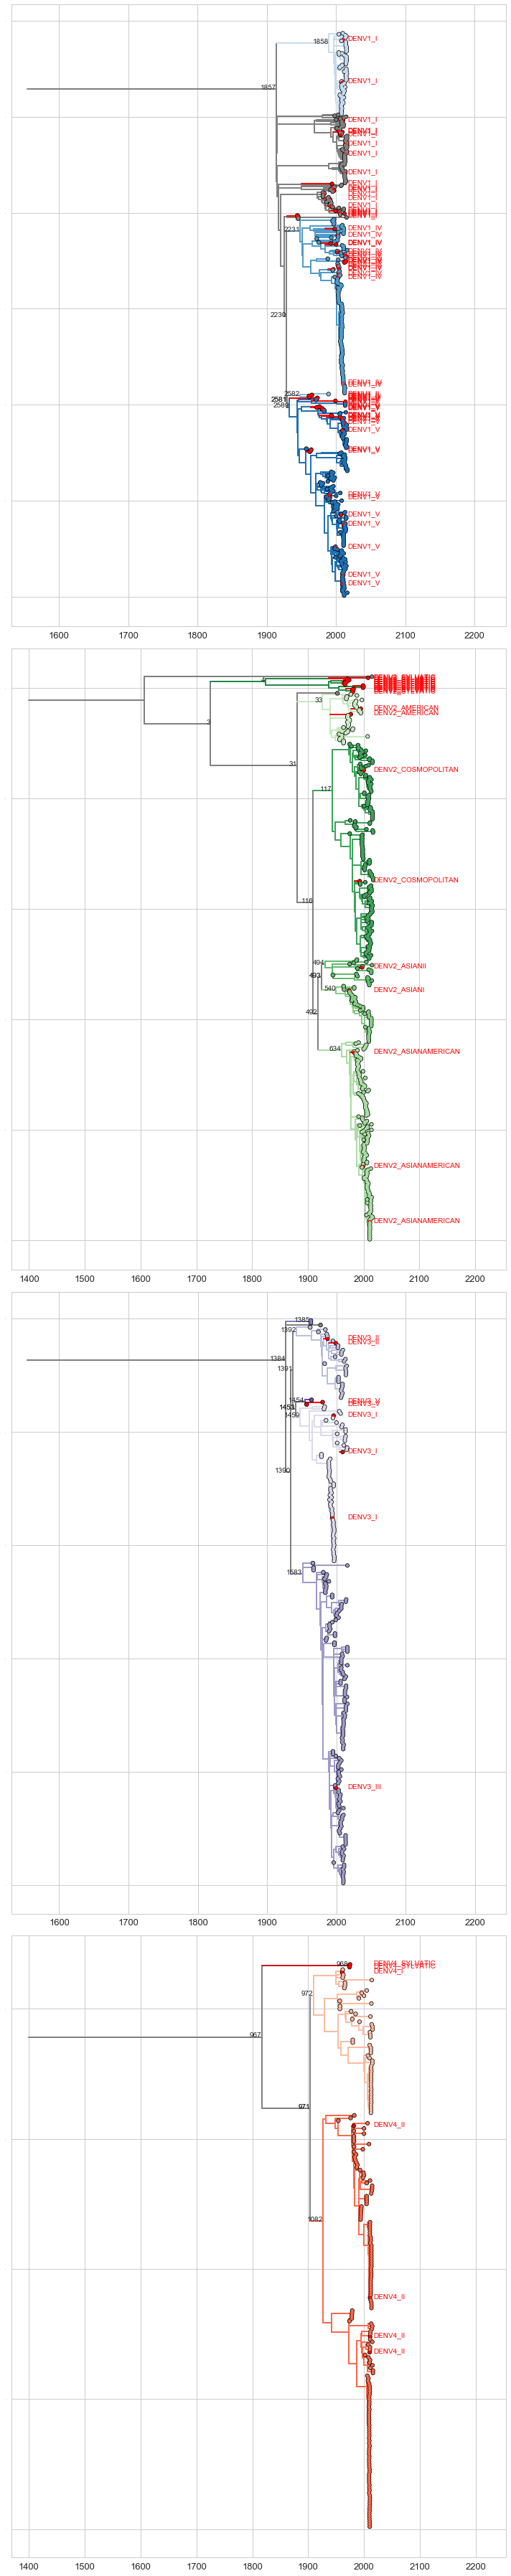

In [31]:
plot_subtrees(tree)

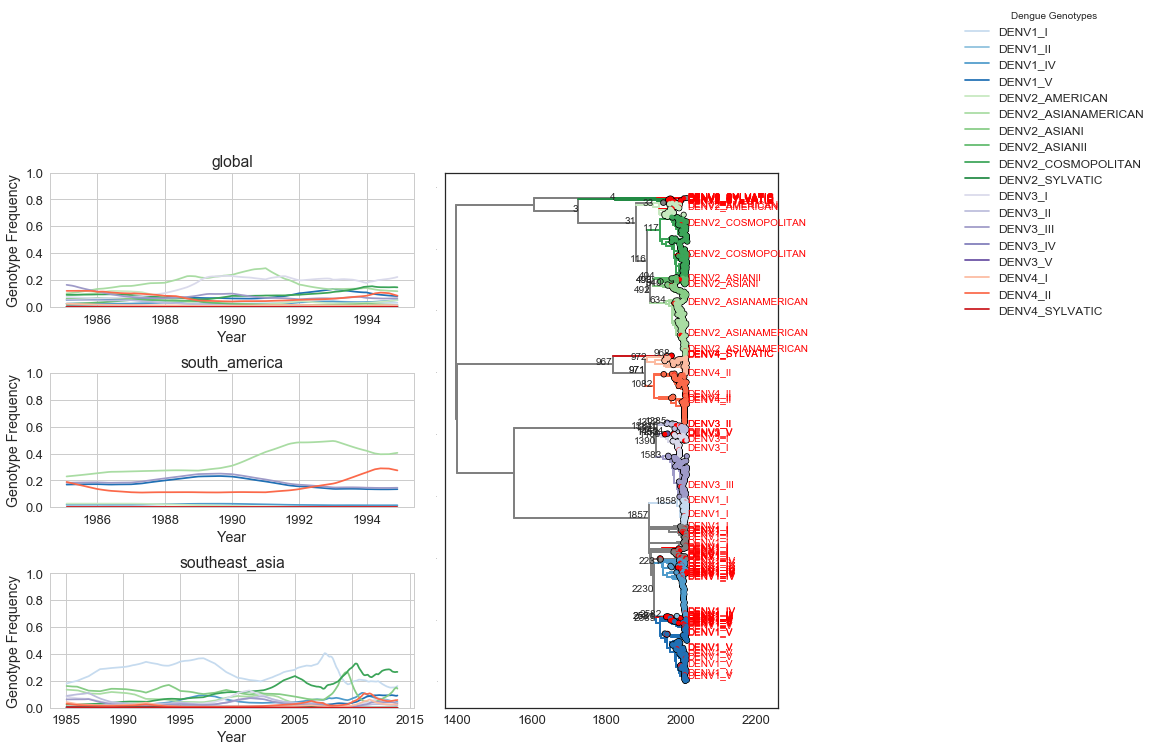

{u'DENV1_I': 1858,
 u'DENV1_II': 2582,
 u'DENV1_IV': 2231,
 u'DENV1_V': 2589,
 'DENV2_AMERICAN': 33,
 u'DENV2_ASIANAMERICAN': 634,
 u'DENV2_ASIANI': 540,
 'DENV2_ASIANII': 494,
 u'DENV2_COSMOPOLITAN': 117,
 u'DENV2_SYLVATIC': 4,
 u'DENV3_I': 1459,
 u'DENV3_II': 1392,
 u'DENV3_III': 1583,
 u'DENV3_IV': 1385,
 'DENV3_V': 1454,
 u'DENV4_I': 972,
 u'DENV4_II': 1082,
 u'DENV4_SYLVATIC': 968}


In [36]:
plot_frequencies_and_tree()
pprint({g : m.traits['clade'] for g,m in mrcas.items()})

In [95]:
# print titers.head()
def load_titers(titer_path):
    titers = pd.read_csv(titer_path)
    for idx, row in titers.iterrows():
        virus_genotype = row['virus_genotype'].split(row['virus_serotype'])[1]
        virus_genotype = row['virus_serotype'] + '_' + virus_genotype
        titers.ix[idx, 'virus_genotype'] = virus_genotype.upper().replace('/', '').replace(' ', '')

        serum_genotype = row['serum_genotype'].split(row['serum_serotype'])[1]
        serum_genotype = row['serum_serotype'] + '_' + serum_genotype
        titers.ix[idx,'serum_genotype'] = serum_genotype.upper().replace('/', '').replace(' ', '')
    return titers

def average_normed_titers(titers):
    avg_titers = titers.groupby(['virus_genotype', 'serum_genotype'])['autologous_norm'].agg('mean')
    avg_titers = { tuple(sorted(k)):v for k,v in avg_titers.to_dict().items()}
    return avg_titers
    
titers = load_titers(titer_path)

In [111]:
def are_cocirculating(genotype1, genotype2, row):
    return row[genotype1] >= 0.1 and row[genotype2] >= 0.1

def avg_len_cocirculating(flag_series):    
    # first value is a True preceded by a False
    start = flag_series.index[flag_series & ~ flag_series.shift(1).fillna(False)]

    # last value is a True followed by a False
    end = flag_series.index[flag_series & ~ flag_series.shift(-1).fillna(False)]
    time_periods = zip(start, end)
    
    len_cocirculating = [end - start for start,end in time_periods]
    try:
        avg_len_cocirculating = float(sum(len_cocirculating)) / float(len(len_cocirculating))
    except ZeroDivisionError:
        avg_len_cocirculating = 0.
        
    return avg_len_cocirculating


def get_cocirculation_stability(region, region_dfs = region_dfs, tree=tree, genotypes=genotypes):
    genotype_pairs = combinations(genotypes, 2)
    
    len_cocirc = {}
    
    for (g1,g2) in genotype_pairs:
        cocirculating_boolean_series = region_dfs[region].apply(lambda x: are_cocirculating(g1,g2,x), axis=1)
        key = tuple(sorted([g1,g2]))
        len_cocirc[key] = avg_len_cocirculating(cocirculating_boolean_series)
    
    return len_cocirc

def both_present((g1, g2), region, region_dfs = region_dfs):
    max_freqs = region_dfs[region].max()
    return max_freqs[g1] >= 0.1 and max_freqs[g2] >=0.1

In [ ]:
len_cocirc = get_cocirculation_stability('southeast_asia')
avg_norm_titers = average_normed_titers(titers)
genotype_pairs = [g for g in sorted(avg_norm_titers.keys()) if g[0] != g[1]]

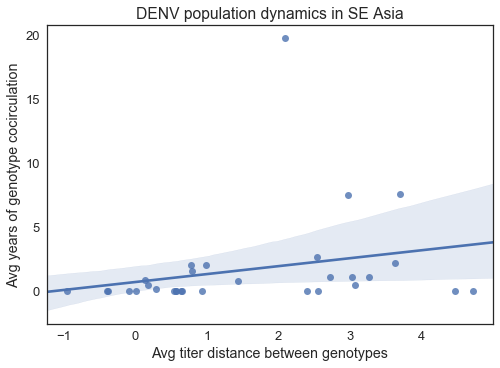

In [114]:
xvals = []
yvals = []

for g in genotype_pairs:
    x = avg_norm_titers[g]
    y = len_cocirc[g]
    if not np.isnan(x):
        if y != 0. or both_present(g, 'southeast_asia'):
            xvals.append(x)
            yvals.append(y)

sns.regplot(pd.Series(xvals),pd.Series(yvals))
plt.xlabel('Avg titer distance between genotypes')
plt.ylabel('Avg years of genotype cocirculation')
plt.title('DENV population dynamics in SE Asia')
# plt.ylim([-5, 10])